# Sampta Experience III

## Purpose
The goal of this notebook is to investigate the **super-resolution capabilities** of different spherical neural representation models. Specifically:
- We **train** our models on Earth topography data sampled at a lower spherical resolution (`lmax=150`). 
- We then evaluate, both **visually** and via **Signal-to-Noise Ratio (SNR)**, how well these models can generalize to a **higher-resolution** grid (`lmax=300`).

By comparing the predictions of various architectures on an unseen, higher-resolution sampling grid, we aim to:
1. Understand whether polynomial- or sine-based spherical networks effectively capture high-frequency components.  
2. Observe how each model behaves when **extrapolating** beyond its training resolution.  

# Experimental Setup (Super-Resolution)
1. **Training Grid**:  
   - We use **Gauss–Legendre** sampling (`L=150`) and its associated spherical harmonic coefficients (Earth2014 at `lmax=150`).  
   - This grid contains fewer points and encodes the Earth topography up to degree 150.  
   - Models are **fit** to these data points (scaled/normalized).

2. **Validation Set**:  
   - We sample 5000 points **uniformly** across the sphere (i.e., random lat/lon) for validation.  
   - This is still limited to `lmax=150` because we use the same Earth2014 expansion.  

3. **Testing Grid (Super-Resolution)**:  
   - For testing, we switch to a **higher-resolution** grid (`lmax=300`).  
   - This grid extends to spherical harmonics of degree 300, capturing more high-frequency details.  
   - We compare the Earth2014 onto this finer grid and compare each model’s prediction to the ground truth.  

4. **Models**  
   - **SphericalNet (Chebyshev)**: Uses Chebyshev polynomial activations.
   - **SphericalNet (Sine)**: Uses sine-based activations.  
   - **Classical SIREN** (`SirenNet`)

5. **Evaluation**  
   - **Visual**: We plot each model’s predicted Earth topography on the `lmax=300` grid, comparing it to the ground truth.  
   - **Numerical**: We compute the **SNR** to assess how well each model captured additional high-frequency details.  
   - **Loss Plots**: We also track training and validation losses for each model.  

In [32]:
import numpy as np
import pyshtools
import spherical_inr as sph
import matplotlib.pyplot as plt


import torch
from sklearn.preprocessing import StandardScaler

In [33]:
def compute_snr(image, noisy_image):
    """
    Computes the Signal-to-Noise Ratio (SNR) between two images.
    """
    
    signal_power = np.mean(np.square(image))
    noise_power = np.mean(np.square(image - noisy_image))
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Data Preprocessing & Visualization
Below, we load and visualize the Earth topography data in three forms: 
- Training grid (`lmax=150`).  
- Validation set (5000 uniformly random points).  
- Test grid (`lmax=300`), the super-resolution data.

In [35]:
L = 150
phi, theta, (nlon, nlat) = sph.sample_s2(L, sampling = "gl", torch_tensor = True)

N_val = 5000
phi_val, theta_val = sph.sample_s2_uniform(N_val, torch_tensor = True)

L_test = 300
phi_test, theta_test, (nlon_test, nlat_test) = sph.sample_s2(L_test, sampling = "gl", torch_tensor = True)

**Load Spherical Harmonic Coefficients**  
- For training/validation, we take `lmax=150`.  
- For testing, `lmax=300` captures more high-frequency details.

In [36]:
coefficients_train = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 150)
coefficients_test = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 300)

In [37]:
world_map = coefficients_train.expand(lon = phi.numpy().flatten(),  colat = theta.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat, nlon)
world_map_val = coefficients_train.expand(lon = phi_val.numpy().flatten(), colat = theta_val.numpy().flatten(), degrees=False, nthreads=0).reshape(N_val)
world_map_test = coefficients_test.expand(lon = phi_test.numpy().flatten(), colat = theta_test.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat_test, nlon_test)

**Visual Inspection** of the Training, Validation, and Test topography.

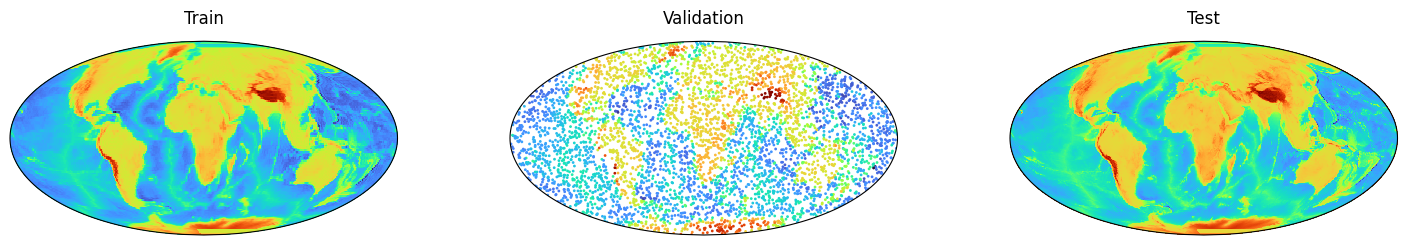

In [38]:
fig = plt.figure(figsize=(15, 5))
subfigs = fig.subfigures(1, 3)
sph.plot_sphere(world_map, molweide=True, cmap = "turbo", title = "Train", fig = subfigs[0])
sph.plot_sphere_scatter(world_map_val, lon = phi_val, lat = theta_val, molweide=True, cmap = "turbo", title = "Validation", fig = subfigs[1], s = 1)
sph.plot_sphere(world_map_test, molweide=True, cmap = "turbo", title = "Test", fig = subfigs[2])
plt.show()

We scale/normalize the training and validation data using `StandardScaler`. 

In [39]:
scaler = StandardScaler()
world_map_scaled = scaler.fit_transform(world_map.reshape(-1, 1)).reshape(nlat, nlon)
world_map_val_scaled = scaler.transform(world_map_val.reshape(-1, 1)).reshape(N_val)


X = torch.stack([theta.flatten(), phi.flatten()], dim=-1).float()
y = torch.tensor(world_map_scaled.copy()).flatten().unsqueeze(1).float()

X_val = torch.stack([theta_val.flatten(), phi_val.flatten()], dim=-1).float()
y_val = torch.tensor(world_map_val_scaled.copy()).flatten().unsqueeze(1).float()

X_test = torch.stack([theta_test.flatten(), phi_test.flatten()], dim=-1).float()

# Move tensors to the selected device
X = X.to(device)
y = y.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

## Model Architectures

In [40]:
dict_train_losses = {}
dict_test_losses = {}
dict_predictions = {}

#### **Model 1: SphericalNet (Chebyshev)**

In [ ]:
shinr = sph.SphericalNet(

    L0 = 15, 
    Q = 3,
    hidden_features = 100, 
    spectral_norm=True,
    activation = sph.Chebyshev(order = 5), 
    first_activation=sph.Chebyshev(order = 20), 
    device=device
    
)

dict_train_losses["SphericalNet (20,5)"], dict_test_losses["SphericalNet (20, 5)"] = sph.train(
    model = shinr, 
    x = X, 
    y = y, 
    epochs = 1000,
    batch_size=2048,
    optimizer = torch.optim.Adam(shinr.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(), 
    validation_data=(X_val, y_val),
    device=device
    )

pred = shinr(X_test).cpu().detach().numpy()
dict_predictions["SphericalNet (20, 5)"] = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(nlat_test, nlon_test)


#### **Model 2: SphericalNet (Sine)**

In [ ]:
shinr = sph.SphericalNet(

    L0 = 15, 
    Q = 3,
    hidden_features = 100, 
    activation = torch.sin, 
    first_activation=lambda x : torch.sin(5*x),
    device=device    
)

dict_train_losses["SphericalSIREN (5)"], dict_test_losses["SphericalSIREN (5)"] = sph.train(
    model = shinr, 
    x = X, 
    y = y, 
    epochs = 1000,
    batch_size=2048,
    optimizer = torch.optim.Adam(shinr.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(),
    validation_data=(X_val, y_val),
    device=device
    )

pred = shinr(X_test).detach().numpy()
dict_predictions["SphericalSIREN (5)"] = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(nlat_test, nlon_test)

#### **Model 3: Classical SIREN**

In [ ]:
siren = sph.SirenNet(

    in_features=2, 
    hidden_features=100,
    n_hidden_layers=5,
    out_features=1,
    first_omega_0=5.0,
    hidden_omega=1.0,
    
).to(device)


dict_train_losses["SIREN"], dict_test_losses["SIREN"] = sph.train(
    model = siren, 
    x = X, 
    y = y, 
    epochs = 1000,
    batch_size=2048,
    optimizer = torch.optim.Adam(siren.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss(), 
    validation_data=(X_val, y_val),
    device = device
    )


pred = siren(X_test).detach().numpy()
dict_predictions["SIREN"] = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(nlat_test, nlon_test)

<div class="alert alert-info">

For the following plots, the **labels** are : 
* **SphericalNet (20, 5)** : Spherical Network with first Chebychev activation of degree $d_0 = 20$ and subsequent activations' degree $d = 5$.
* **SphericalSIREN (5)** : SphericalSiren with first activation $\sigma_0(x) = \sin(\omega_0 x)$ with $\omega_0 = 5$; subsequent activations are $\sigma(x) = \sin(x)$.
* **SIREN** : Siren Network with $\omega_0 = 5$.

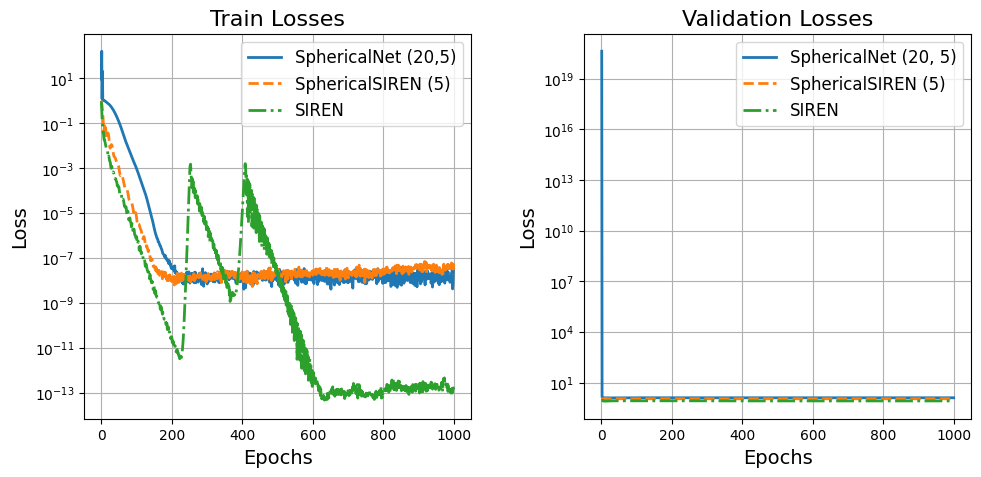

In [ ]:
fig = plt.figure(figsize=(10, 5))
subfigs = fig.subfigures(1, 2)
sph.plot_losses(dict_train_losses, fig = subfigs[0], title = "Train Losses")
sph.plot_losses(dict_test_losses, fig = subfigs[1], title = "Validation Losses")
plt.savefig("figures/losses.pdf")
plt.show()

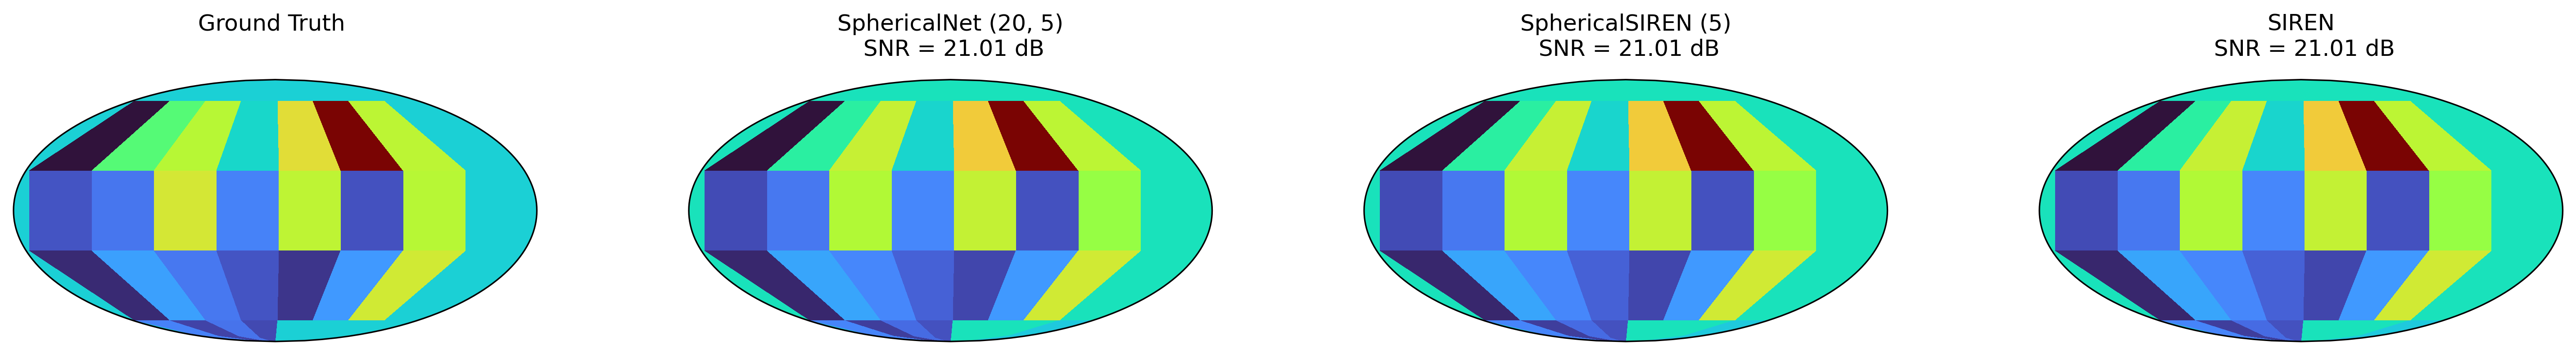

In [31]:
fig = plt.figure(figsize=(20, 10), dpi = 300)
subfigs = fig.subfigures(1, 4)

sph.plot_sphere(world_map_test, cmap = "turbo", title = "Ground Truth \n", fig=subfigs[0], molweide=True)

for i, (label, pred) in enumerate(dict_predictions.items()):
    snr = compute_snr(world_map_test, pred)
    sph.plot_sphere(pred, cmap = "turbo", title = label + f"\n SNR = {snr:.2f} dB",  fig=subfigs[i+1], molweide=True)

plt.show()
